In [5]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

import seaborn as sns
import yfinance as yf
import ta

In [6]:
ativo = yf.download('VALE3.SA')
ativo

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,3.500000,3.542500,3.500000,3.500000,1.531955,585600
2000-01-04,3.466666,3.474166,3.416666,3.416666,1.495479,782400
2000-01-05,3.375000,3.416666,3.375000,3.416666,1.495479,1876800
2000-01-06,3.416666,3.500000,3.416666,3.416666,1.495479,792000
2000-01-07,3.458333,3.559166,3.458333,3.541666,1.550192,5347200
...,...,...,...,...,...,...
2024-04-18,62.689999,62.720001,61.910000,62.340000,62.340000,19932500
2024-04-19,62.240002,63.549999,62.090000,63.360001,63.360001,32882400
2024-04-22,63.029999,63.580002,62.299999,63.330002,63.330002,27171200


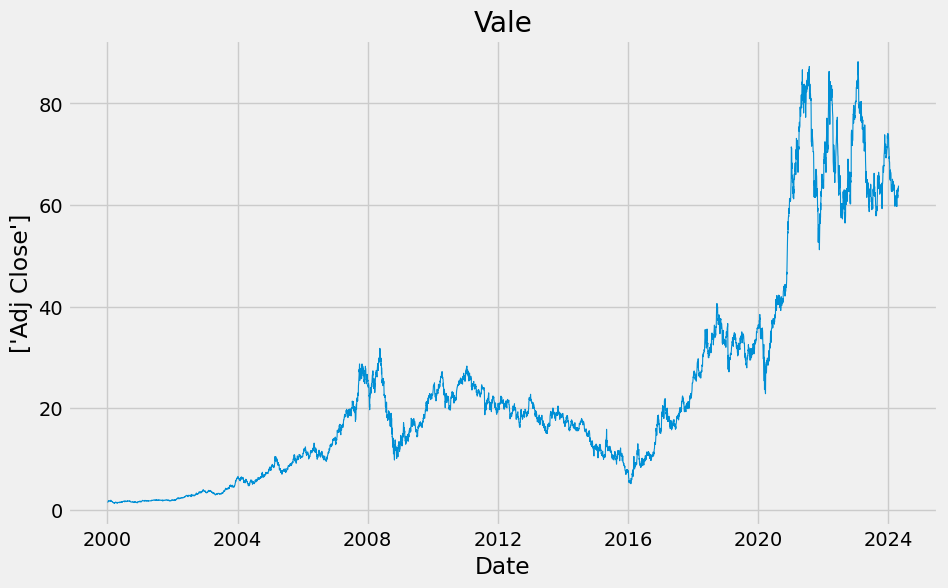

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


In [7]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel(['Adj Close'])
plt.title('Vale')
plt.plot(ativo['Adj Close'],linewidth=0.8)
plt.show()
print(ativo.columns)

<Axes: ylabel='Density'>

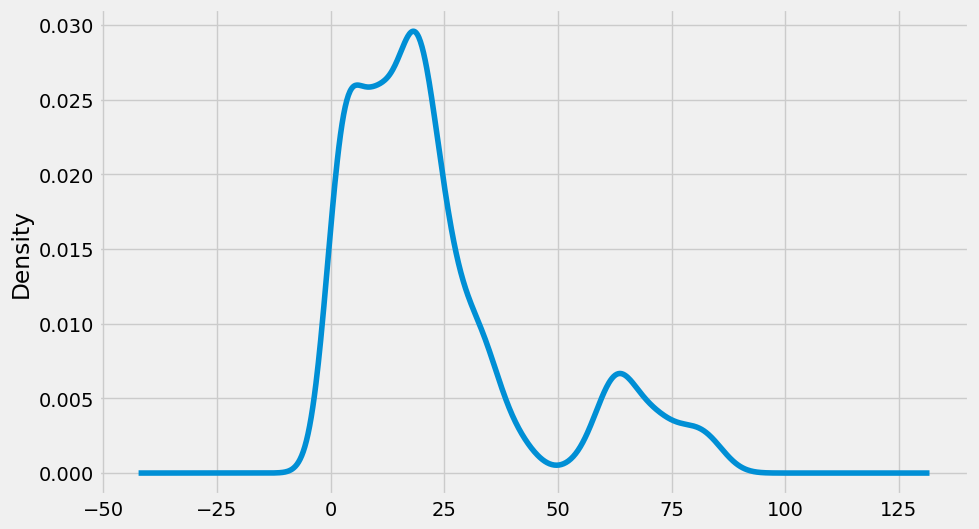

In [8]:
ativo['Adj Close'].plot(kind='kde')

In [9]:
import ta.momentum
import ta.trend
import ta.volatility
import ta.volume


ativo['sma5'] = ta.trend.sma_indicator(ativo['Adj Close'],window = 5)
ativo['sma10'] = ta.trend.sma_indicator(ativo['Adj Close'],window = 10)
ativo['sma15'] = ta.trend.sma_indicator(ativo['Adj Close'],window = 15)
ativo['sma20'] = ta.trend.sma_indicator(ativo['Adj Close'],window = 20)
ativo['sma30'] = ta.trend.sma_indicator(ativo['Adj Close'],window = 30)
ativo['sma50'] = ta.trend.sma_indicator(ativo['Adj Close'],window = 50)
ativo['sma80'] = ta.trend.sma_indicator(ativo['Adj Close'],window = 80)
ativo['sma100'] = ta.trend.sma_indicator(ativo['Adj Close'],window = 100)
ativo['sma200'] = ta.trend.sma_indicator(ativo['Adj Close'],window = 200)

ativo['rsi'] = ta.momentum.RSIIndicator(ativo['Adj Close']).rsi() # type: ignore
ativo['cci'] = ta.trend.cci(ativo['High'], ativo['Low'], ativo['Close'], window=20, constant=0.015)
bb_indicator = ta.volatility.BollingerBands(ativo['Adj Close'])
ativo['bb_high'] = bb_indicator.bollinger_hband()
ativo['bb_low'] = bb_indicator.bollinger_lband()
ativo['obv'] = ta.volume.OnBalanceVolumeIndicator(close=ativo['Adj Close'], volume=ativo['Volume']).on_balance_volume()

ativo['rsi_overbought'] = (ativo['rsi'] >= 70).astype(int)
ativo['rsi_oversold'] = (ativo['rsi'] <= 30).astype(int)
ativo['above_bb_high'] = (ativo['Adj Close'] >= ativo['bb_high']).astype(int)
ativo['below_bb_low'] = (ativo['Adj Close'] <= ativo['bb_low']).astype(int)
ativo['obv_divergence_10_days'] = ativo['obv'].diff().rolling(10).sum() - ativo['Adj Close'].diff().rolling(10).sum()
ativo['obv_divergence_20_days'] = ativo['obv'].diff().rolling(20).sum() - ativo['Adj Close'].diff().rolling(20).sum()
ativo['cci_high'] = (ativo['cci'] >= 120).astype(int)
ativo['cci_low'] = (ativo['cci'] <= -120).astype(int)
ativo['sma5 > sma10'] = (ativo['sma5'] > ativo['sma10']).astype(int)
ativo['sma10 > sma15'] = (ativo['sma10'] > ativo['sma15']).astype(int)
ativo['sma15 > sma20'] = (ativo['sma15'] > ativo['sma20']).astype(int)
ativo['sma20 > sma30'] = (ativo['sma20'] > ativo['sma30']).astype(int)
ativo['sma30 > sma50'] = (ativo['sma30'] > ativo['sma50']).astype(int)
ativo['sma50 > sma80'] = (ativo['sma50'] > ativo['sma80']).astype(int)
ativo['sma80 > sma100'] = (ativo['sma80'] > ativo['sma100']).astype(int)
ativo['sma100 > sma200'] = (ativo['sma100'] > ativo['sma200']).astype(int)

ativo = ativo.dropna()
ativo

,Open,High,Low,Close,Adj Close,Volume,sma5,sma10,sma15,sma20,...,cci_high,cci_low,sma5 > sma10,sma10 > sma15,sma15 > sma20,sma20 > sma30,sma30 > sma50,sma50 > sma80,sma80 > sma100,sma100 > sma200
Date,,,,,,,,,,,,,,,,,,,,,
2000-10-06,3.583333,3.583333,3.500000,3.583333,1.568429,676800,1.553839,1.546362,1.545937,1.581105,...,0,0,1,1,0,0,0,0,1,1
2000-10-09,3.583333,3.583333,3.583333,3.583333,1.568429,4800,1.561134,1.547821,1.543991,1.573445,...,0,0,1,1,0,0,0,0,1,1
2000-10-10,3.583333,3.583333,3.583333,3.583333,1.568429,0,1.568429,1.549645,1.543991,1.566515,...,0,0,1,1,0,0,0,0,1,1
2000-10-11,3.582500,3.583333,3.420833,3.420833,1.497303,100800,1.554204,1.546909,1.541681,1.556575,...,0,0,1,1,0,0,0,0,1,1
2000-10-12,3.420833,3.420833,3.420833,3.420833,1.497303,0,1.539979,1.543444,1.540587,1.548095,...,0,1,0,1,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-18,62.689999,62.720001,61.910000,62.340000,62.340000,19932500,61.902000,61.820000,61.574000,61.384500,...,0,0,1,1,1,0,0,0,0,1
2024-04-19,62.240002,63.549999,62.090000,63.360001,63.360001,32882400,62.248000,62.185000,61.742667,61.469500,...,1,0,1,1,1,1,0,0,0,1
2024-04-22,63.029999,63.580002,62.299999,63.330002,63.330002,27171200,62.516000,62.221000,61.883333,61.588500,...,0,0,1,1,1,1,0,0,0,1


(array([1483., 1568., 1291.,  546.,  164.,   12.,  191.,  338.,  173.,
         140.]),
 array([ 1.34957898, 10.0370515 , 18.72452402, 27.41199654, 36.09946907,
        44.78694159, 53.47441411, 62.16188663, 70.84935915, 79.53683168,
        88.2243042 ]),
 <BarContainer object of 10 artists>)

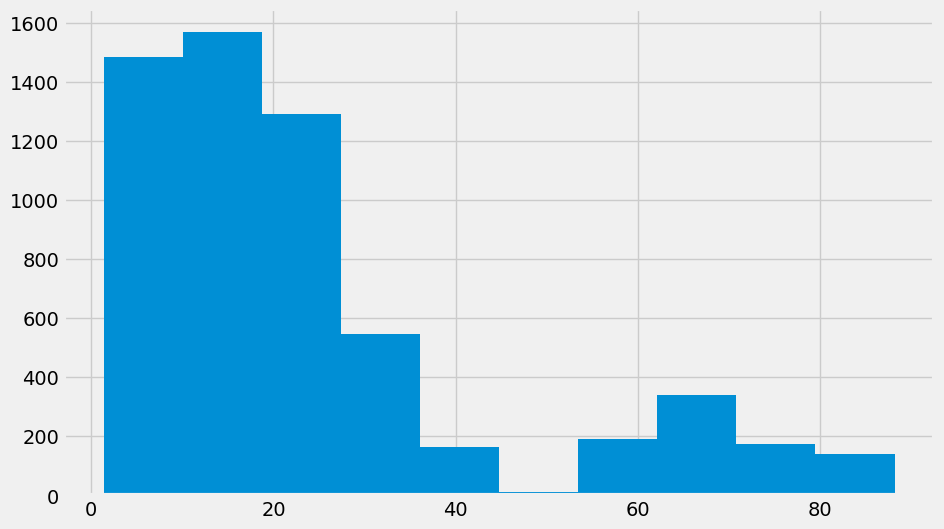

In [10]:
plt.figure()
plt.hist(ativo['Adj Close'])


Text(0.5, 1.0, 'Correlação dos indicadores')

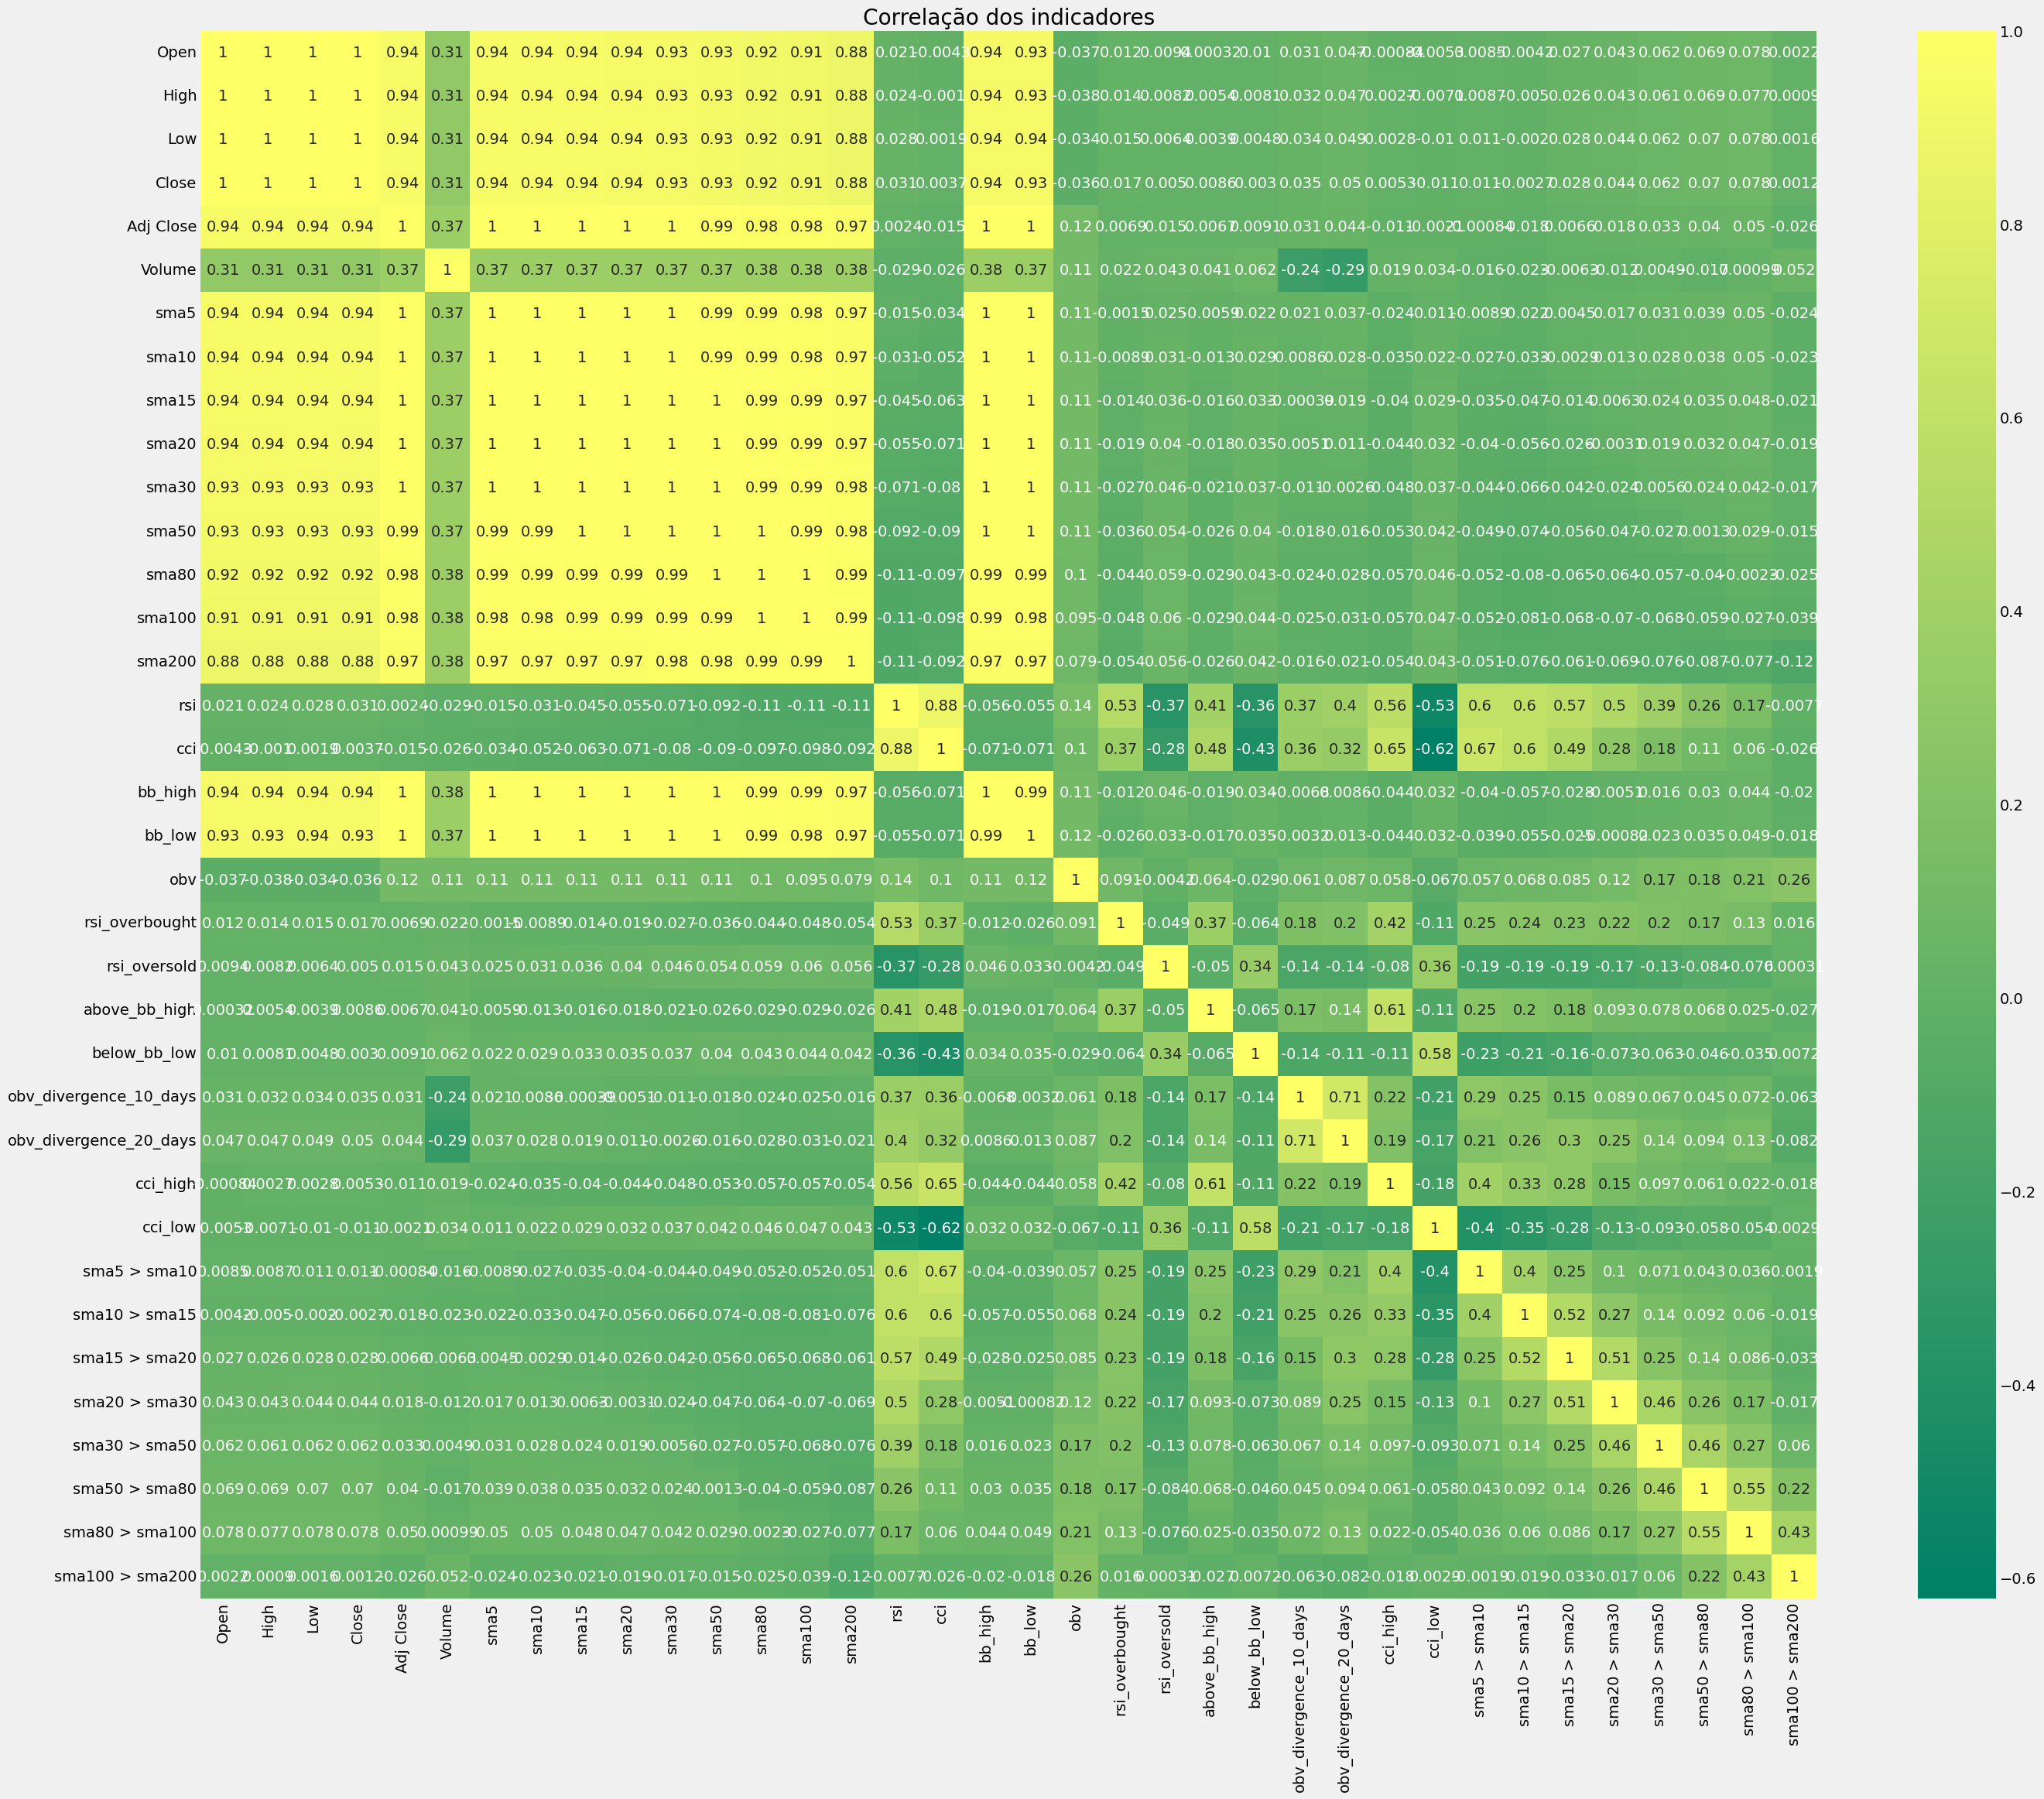

In [11]:
plt.figure(figsize=(30,25))
sns.heatmap(ativo.corr(),annot=True,cmap='summer')
plt.title('Correlação dos indicadores')

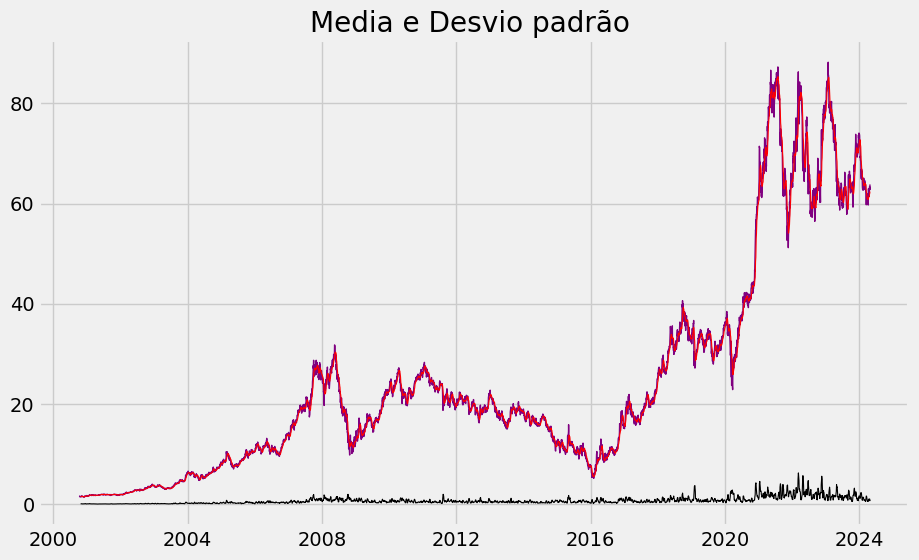

Resultados : 
Teste estatisticos        -0.659625
p-value                    0.856932
No. of lags                7.000000
Total de observações    5898.000000
Valores : (1%)            -3.431459
dtype: float64
Teste estatisticos        -0.659625
p-value                    0.856932
No. of lags                7.000000
Total de observações    5898.000000
Valores : (1%)            -3.431459
Valores : (5%)            -2.862030
dtype: float64
Teste estatisticos        -0.659625
p-value                    0.856932
No. of lags                7.000000
Total de observações    5898.000000
Valores : (1%)            -3.431459
Valores : (5%)            -2.862030
Valores : (10%)           -2.567031
dtype: float64


In [12]:
def test_stationary(timeseries):
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    plt.plot(timeseries,color='purple',label='Original',linewidth = 1)
    plt.plot(rolmean,color='red',label = 'Rolling Mean',linewidth = 0.8)
    plt.plot(rolstd,color='Black',label='Rolling Std',linewidth = 0.8)
    plt.title('Media e Desvio padrão ')
    plt.show(block=False)

    print('Resultados : ')
    adft = adfuller(timeseries,autolag='AIC')

    output = pd.Series(adft[0:4],index=['Teste estatisticos','p-value','No. of lags','Total de observações'])

    for key,values in adft[4].items():
        output['Valores : (%s)'%key] = values
        print(output)

test_stationary(ativo['Adj Close'])

<Figure size 1000x600 with 0 Axes>

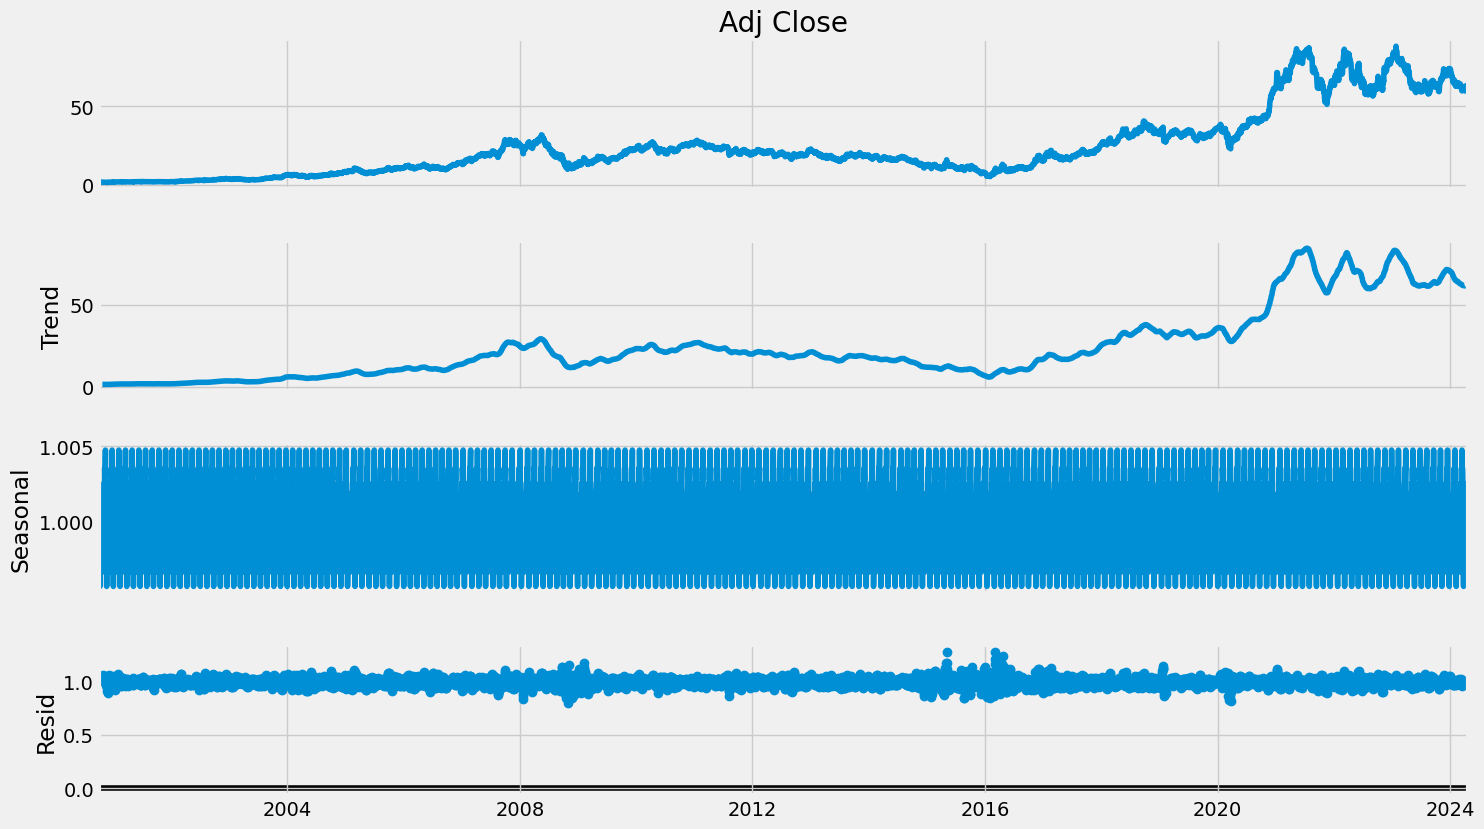

In [16]:
resultado = seasonal_decompose(ativo['Adj Close'],model='multiplicative',period=30)

fig = plt.figure()
fig = resultado.plot()
fig.set_size_inches(16,9)

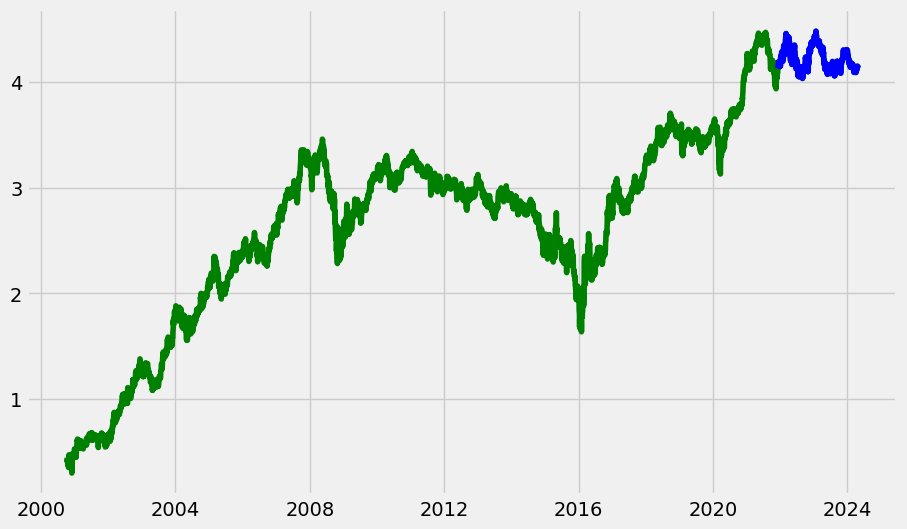

In [30]:
df_log = np.log(ativo['Adj Close'])


train_data, test_data = df_log[3:int(len(df_log)*0.9)],df_log[int(len(df_log)*0.9):]

plt.figure()
plt.plot(df_log,'green',label='Data treino')
plt.plot(test_data,'blue',label=' Data teste')

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-23784.445, Time=0.39 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-23782.815, Time=0.41 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-23782.836, Time=1.59 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-23782.525, Time=0.25 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-23791.378, Time=3.21 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-23806.971, Time=1.09 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-23798.518, Time=0.44 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-23800.323, Time=1.05 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-23801.530, Time=2.17 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-23806.554, Time=0.66 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-23802.356, Time=0.52 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-23798.922, Time=3.71 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-23803.884, Time=0.52 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0] intercept
Total fit time: 16.052 sec

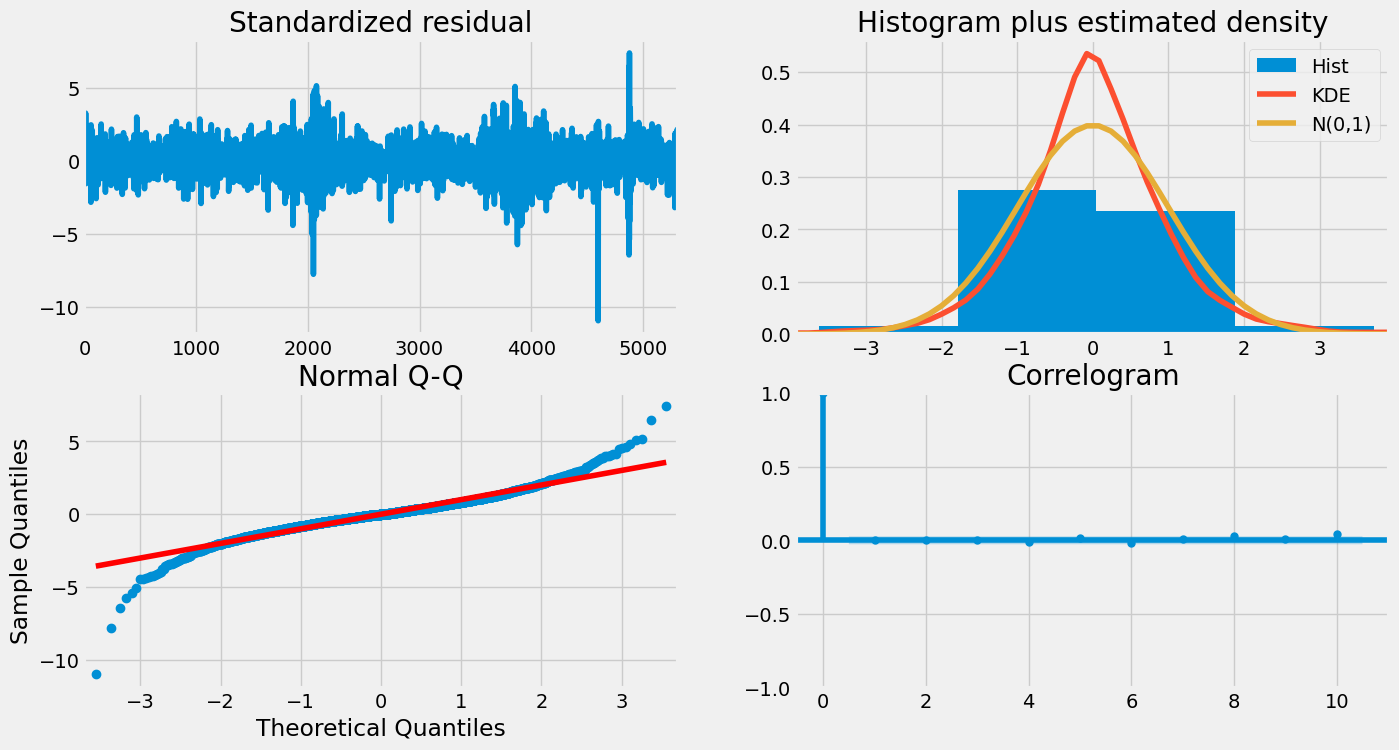

In [32]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       
                      max_p=3, max_q=3, 
                      m=1,              
                      d=None,           
                      seasonal=False,   
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [77]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(endog=train_data,order=(1,1,2))  
fitted = model.fit()  
print(fitted.summary())

c:\Users\lauro.telles\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\lauro.telles\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\lauro.telles\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                 5312
Model:                 ARIMA(1, 1, 2)   Log Likelihood               11905.764
Date:                Wed, 24 Apr 2024   AIC                         -23803.527
Time:                        18:04:31   BIC                         -23777.217
Sample:                             0   HQIC                        -23794.334
                               - 5312                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5159      0.095      5.418      0.000       0.329       0.703
ma.L1         -0.5092      0.094     -5.416      0.000      -0.693      -0.325
ma.L2         -0.0626      0.009     -6.789      0.0

c:\Users\lauro.telles\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


ConversionError: Failed to convert value(s) to axis units: array([Timestamp('2021-12-10 00:00:00'), Timestamp('2021-12-13 00:00:00'),
       Timestamp('2021-12-14 00:00:00'), Timestamp('2021-12-15 00:00:00'),
       Timestamp('2021-12-16 00:00:00'), Timestamp('2021-12-17 00:00:00'),
       Timestamp('2021-12-20 00:00:00'), Timestamp('2021-12-21 00:00:00'),
       Timestamp('2021-12-22 00:00:00'), Timestamp('2021-12-23 00:00:00'),
       Timestamp('2021-12-27 00:00:00'), Timestamp('2021-12-28 00:00:00'),
       Timestamp('2021-12-29 00:00:00'), Timestamp('2021-12-30 00:00:00'),
       Timestamp('2022-01-03 00:00:00'), Timestamp('2022-01-04 00:00:00'),
       Timestamp('2022-01-05 00:00:00'), Timestamp('2022-01-06 00:00:00'),
       Timestamp('2022-01-07 00:00:00'), Timestamp('2022-01-10 00:00:00'),
       Timestamp('2022-01-11 00:00:00'), Timestamp('2022-01-12 00:00:00'),
       Timestamp('2022-01-13 00:00:00'), Timestamp('2022-01-14 00:00:00'),
       Timestamp('2022-01-17 00:00:00'), Timestamp('2022-01-18 00:00:00'),
       Timestamp('2022-01-19 00:00:00'), Timestamp('2022-01-20 00:00:00'),
       Timestamp('2022-01-21 00:00:00'), Timestamp('2022-01-24 00:00:00'),
       Timestamp('2022-01-25 00:00:00'), Timestamp('2022-01-26 00:00:00'),
       Timestamp('2022-01-27 00:00:00'), Timestamp('2022-01-28 00:00:00'),
       Timestamp('2022-01-31 00:00:00'), Timestamp('2022-02-01 00:00:00'),
       Timestamp('2022-02-02 00:00:00'), Timestamp('2022-02-03 00:00:00'),
       Timestamp('2022-02-04 00:00:00'), Timestamp('2022-02-07 00:00:00'),
       Timestamp('2022-02-08 00:00:00'), Timestamp('2022-02-09 00:00:00'),
       Timestamp('2022-02-10 00:00:00'), Timestamp('2022-02-11 00:00:00'),
       Timestamp('2022-02-14 00:00:00'), Timestamp('2022-02-15 00:00:00'),
       Timestamp('2022-02-16 00:00:00'), Timestamp('2022-02-17 00:00:00'),
       Timestamp('2022-02-18 00:00:00'), Timestamp('2022-02-21 00:00:00'),
       Timestamp('2022-02-22 00:00:00'), Timestamp('2022-02-23 00:00:00'),
       Timestamp('2022-02-24 00:00:00'), Timestamp('2022-02-25 00:00:00'),
       Timestamp('2022-03-02 00:00:00'), Timestamp('2022-03-03 00:00:00'),
       Timestamp('2022-03-04 00:00:00'), Timestamp('2022-03-07 00:00:00'),
       Timestamp('2022-03-08 00:00:00'), Timestamp('2022-03-09 00:00:00'),
       Timestamp('2022-03-10 00:00:00'), Timestamp('2022-03-11 00:00:00'),
       Timestamp('2022-03-14 00:00:00'), Timestamp('2022-03-15 00:00:00'),
       Timestamp('2022-03-16 00:00:00'), Timestamp('2022-03-17 00:00:00'),
       Timestamp('2022-03-18 00:00:00'), Timestamp('2022-03-21 00:00:00'),
       Timestamp('2022-03-22 00:00:00'), Timestamp('2022-03-23 00:00:00'),
       Timestamp('2022-03-24 00:00:00'), Timestamp('2022-03-25 00:00:00'),
       Timestamp('2022-03-28 00:00:00'), Timestamp('2022-03-29 00:00:00'),
       Timestamp('2022-03-30 00:00:00'), Timestamp('2022-03-31 00:00:00'),
       Timestamp('2022-04-01 00:00:00'), Timestamp('2022-04-04 00:00:00'),
       Timestamp('2022-04-05 00:00:00'), Timestamp('2022-04-06 00:00:00'),
       Timestamp('2022-04-07 00:00:00'), Timestamp('2022-04-08 00:00:00'),
       Timestamp('2022-04-11 00:00:00'), Timestamp('2022-04-12 00:00:00'),
       Timestamp('2022-04-13 00:00:00'), Timestamp('2022-04-14 00:00:00'),
       Timestamp('2022-04-18 00:00:00'), Timestamp('2022-04-19 00:00:00'),
       Timestamp('2022-04-20 00:00:00'), Timestamp('2022-04-22 00:00:00'),
       Timestamp('2022-04-25 00:00:00'), Timestamp('2022-04-26 00:00:00'),
       Timestamp('2022-04-27 00:00:00'), Timestamp('2022-04-28 00:00:00'),
       Timestamp('2022-04-29 00:00:00'), Timestamp('2022-05-02 00:00:00'),
       Timestamp('2022-05-03 00:00:00'), Timestamp('2022-05-04 00:00:00'),
       Timestamp('2022-05-05 00:00:00'), Timestamp('2022-05-06 00:00:00'),
       Timestamp('2022-05-09 00:00:00'), Timestamp('2022-05-10 00:00:00'),
       Timestamp('2022-05-11 00:00:00'), Timestamp('2022-05-12 00:00:00'),
       Timestamp('2022-05-13 00:00:00'), Timestamp('2022-05-16 00:00:00'),
       Timestamp('2022-05-17 00:00:00'), Timestamp('2022-05-18 00:00:00'),
       Timestamp('2022-05-19 00:00:00'), Timestamp('2022-05-20 00:00:00'),
       Timestamp('2022-05-23 00:00:00'), Timestamp('2022-05-24 00:00:00'),
       Timestamp('2022-05-25 00:00:00'), Timestamp('2022-05-26 00:00:00'),
       Timestamp('2022-05-27 00:00:00'), Timestamp('2022-05-30 00:00:00'),
       Timestamp('2022-05-31 00:00:00'), Timestamp('2022-06-01 00:00:00'),
       Timestamp('2022-06-02 00:00:00'), Timestamp('2022-06-03 00:00:00'),
       Timestamp('2022-06-06 00:00:00'), Timestamp('2022-06-07 00:00:00'),
       Timestamp('2022-06-08 00:00:00'), Timestamp('2022-06-09 00:00:00'),
       Timestamp('2022-06-10 00:00:00'), Timestamp('2022-06-13 00:00:00'),
       Timestamp('2022-06-14 00:00:00'), Timestamp('2022-06-15 00:00:00'),
       Timestamp('2022-06-17 00:00:00'), Timestamp('2022-06-20 00:00:00'),
       Timestamp('2022-06-21 00:00:00'), Timestamp('2022-06-22 00:00:00'),
       Timestamp('2022-06-23 00:00:00'), Timestamp('2022-06-24 00:00:00'),
       Timestamp('2022-06-27 00:00:00'), Timestamp('2022-06-28 00:00:00'),
       Timestamp('2022-06-29 00:00:00'), Timestamp('2022-06-30 00:00:00'),
       Timestamp('2022-07-01 00:00:00'), Timestamp('2022-07-04 00:00:00'),
       Timestamp('2022-07-05 00:00:00'), Timestamp('2022-07-06 00:00:00'),
       Timestamp('2022-07-07 00:00:00'), Timestamp('2022-07-08 00:00:00'),
       Timestamp('2022-07-11 00:00:00'), Timestamp('2022-07-12 00:00:00'),
       Timestamp('2022-07-13 00:00:00'), Timestamp('2022-07-14 00:00:00'),
       Timestamp('2022-07-15 00:00:00'), Timestamp('2022-07-18 00:00:00'),
       Timestamp('2022-07-19 00:00:00'), Timestamp('2022-07-20 00:00:00'),
       Timestamp('2022-07-21 00:00:00'), Timestamp('2022-07-22 00:00:00'),
       Timestamp('2022-07-25 00:00:00'), Timestamp('2022-07-26 00:00:00'),
       Timestamp('2022-07-27 00:00:00'), Timestamp('2022-07-28 00:00:00'),
       Timestamp('2022-07-29 00:00:00'), Timestamp('2022-08-01 00:00:00'),
       Timestamp('2022-08-02 00:00:00'), Timestamp('2022-08-03 00:00:00'),
       Timestamp('2022-08-04 00:00:00'), Timestamp('2022-08-05 00:00:00'),
       Timestamp('2022-08-08 00:00:00'), Timestamp('2022-08-09 00:00:00'),
       Timestamp('2022-08-10 00:00:00'), Timestamp('2022-08-11 00:00:00'),
       Timestamp('2022-08-12 00:00:00'), Timestamp('2022-08-15 00:00:00'),
       Timestamp('2022-08-16 00:00:00'), Timestamp('2022-08-17 00:00:00'),
       Timestamp('2022-08-18 00:00:00'), Timestamp('2022-08-19 00:00:00'),
       Timestamp('2022-08-22 00:00:00'), Timestamp('2022-08-23 00:00:00'),
       Timestamp('2022-08-24 00:00:00'), Timestamp('2022-08-25 00:00:00'),
       Timestamp('2022-08-26 00:00:00'), Timestamp('2022-08-29 00:00:00'),
       Timestamp('2022-08-30 00:00:00'), Timestamp('2022-08-31 00:00:00'),
       Timestamp('2022-09-01 00:00:00'), Timestamp('2022-09-02 00:00:00'),
       Timestamp('2022-09-05 00:00:00'), Timestamp('2022-09-06 00:00:00'),
       Timestamp('2022-09-08 00:00:00'), Timestamp('2022-09-09 00:00:00'),
       Timestamp('2022-09-12 00:00:00'), Timestamp('2022-09-13 00:00:00'),
       Timestamp('2022-09-14 00:00:00'), Timestamp('2022-09-15 00:00:00'),
       Timestamp('2022-09-16 00:00:00'), Timestamp('2022-09-19 00:00:00'),
       Timestamp('2022-09-20 00:00:00'), Timestamp('2022-09-21 00:00:00'),
       Timestamp('2022-09-22 00:00:00'), Timestamp('2022-09-23 00:00:00'),
       Timestamp('2022-09-26 00:00:00'), Timestamp('2022-09-27 00:00:00'),
       Timestamp('2022-09-28 00:00:00'), Timestamp('2022-09-29 00:00:00'),
       Timestamp('2022-09-30 00:00:00'), Timestamp('2022-10-03 00:00:00'),
       Timestamp('2022-10-04 00:00:00'), Timestamp('2022-10-05 00:00:00'),
       Timestamp('2022-10-06 00:00:00'), Timestamp('2022-10-07 00:00:00'),
       Timestamp('2022-10-10 00:00:00'), Timestamp('2022-10-11 00:00:00'),
       Timestamp('2022-10-13 00:00:00'), Timestamp('2022-10-14 00:00:00'),
       Timestamp('2022-10-17 00:00:00'), Timestamp('2022-10-18 00:00:00'),
       Timestamp('2022-10-19 00:00:00'), Timestamp('2022-10-20 00:00:00'),
       Timestamp('2022-10-21 00:00:00'), Timestamp('2022-10-24 00:00:00'),
       Timestamp('2022-10-25 00:00:00'), Timestamp('2022-10-26 00:00:00'),
       Timestamp('2022-10-27 00:00:00'), Timestamp('2022-10-28 00:00:00'),
       Timestamp('2022-10-31 00:00:00'), Timestamp('2022-11-01 00:00:00'),
       Timestamp('2022-11-03 00:00:00'), Timestamp('2022-11-04 00:00:00'),
       Timestamp('2022-11-07 00:00:00'), Timestamp('2022-11-08 00:00:00'),
       Timestamp('2022-11-09 00:00:00'), Timestamp('2022-11-10 00:00:00'),
       Timestamp('2022-11-11 00:00:00'), Timestamp('2022-11-14 00:00:00'),
       Timestamp('2022-11-16 00:00:00'), Timestamp('2022-11-17 00:00:00'),
       Timestamp('2022-11-18 00:00:00'), Timestamp('2022-11-21 00:00:00'),
       Timestamp('2022-11-22 00:00:00'), Timestamp('2022-11-23 00:00:00'),
       Timestamp('2022-11-24 00:00:00'), Timestamp('2022-11-25 00:00:00'),
       Timestamp('2022-11-28 00:00:00'), Timestamp('2022-11-29 00:00:00'),
       Timestamp('2022-11-30 00:00:00'), Timestamp('2022-12-01 00:00:00'),
       Timestamp('2022-12-02 00:00:00'), Timestamp('2022-12-05 00:00:00'),
       Timestamp('2022-12-06 00:00:00'), Timestamp('2022-12-07 00:00:00'),
       Timestamp('2022-12-08 00:00:00'), Timestamp('2022-12-09 00:00:00'),
       Timestamp('2022-12-12 00:00:00'), Timestamp('2022-12-13 00:00:00'),
       Timestamp('2022-12-14 00:00:00'), Timestamp('2022-12-15 00:00:00'),
       Timestamp('2022-12-16 00:00:00'), Timestamp('2022-12-19 00:00:00'),
       Timestamp('2022-12-20 00:00:00'), Timestamp('2022-12-21 00:00:00'),
       Timestamp('2022-12-22 00:00:00'), Timestamp('2022-12-23 00:00:00'),
       Timestamp('2022-12-26 00:00:00'), Timestamp('2022-12-27 00:00:00'),
       Timestamp('2022-12-28 00:00:00'), Timestamp('2022-12-29 00:00:00'),
       Timestamp('2023-01-02 00:00:00'), Timestamp('2023-01-03 00:00:00'),
       Timestamp('2023-01-04 00:00:00'), Timestamp('2023-01-05 00:00:00'),
       Timestamp('2023-01-06 00:00:00'), Timestamp('2023-01-09 00:00:00'),
       Timestamp('2023-01-10 00:00:00'), Timestamp('2023-01-11 00:00:00'),
       Timestamp('2023-01-12 00:00:00'), Timestamp('2023-01-13 00:00:00'),
       Timestamp('2023-01-16 00:00:00'), Timestamp('2023-01-17 00:00:00'),
       Timestamp('2023-01-18 00:00:00'), Timestamp('2023-01-19 00:00:00'),
       Timestamp('2023-01-20 00:00:00'), Timestamp('2023-01-23 00:00:00'),
       Timestamp('2023-01-24 00:00:00'), Timestamp('2023-01-25 00:00:00'),
       Timestamp('2023-01-26 00:00:00'), Timestamp('2023-01-27 00:00:00'),
       Timestamp('2023-01-30 00:00:00'), Timestamp('2023-01-31 00:00:00'),
       Timestamp('2023-02-01 00:00:00'), Timestamp('2023-02-02 00:00:00'),
       Timestamp('2023-02-03 00:00:00'), Timestamp('2023-02-06 00:00:00'),
       Timestamp('2023-02-07 00:00:00'), Timestamp('2023-02-08 00:00:00'),
       Timestamp('2023-02-09 00:00:00'), Timestamp('2023-02-10 00:00:00'),
       Timestamp('2023-02-13 00:00:00'), Timestamp('2023-02-14 00:00:00'),
       Timestamp('2023-02-15 00:00:00'), Timestamp('2023-02-16 00:00:00'),
       Timestamp('2023-02-17 00:00:00'), Timestamp('2023-02-22 00:00:00'),
       Timestamp('2023-02-23 00:00:00'), Timestamp('2023-02-24 00:00:00'),
       Timestamp('2023-02-27 00:00:00'), Timestamp('2023-02-28 00:00:00'),
       Timestamp('2023-03-01 00:00:00'), Timestamp('2023-03-02 00:00:00'),
       Timestamp('2023-03-03 00:00:00'), Timestamp('2023-03-06 00:00:00'),
       Timestamp('2023-03-07 00:00:00'), Timestamp('2023-03-08 00:00:00'),
       Timestamp('2023-03-09 00:00:00'), Timestamp('2023-03-10 00:00:00'),
       Timestamp('2023-03-13 00:00:00'), Timestamp('2023-03-14 00:00:00'),
       Timestamp('2023-03-15 00:00:00'), Timestamp('2023-03-16 00:00:00'),
       Timestamp('2023-03-17 00:00:00'), Timestamp('2023-03-20 00:00:00'),
       Timestamp('2023-03-21 00:00:00'), Timestamp('2023-03-22 00:00:00'),
       Timestamp('2023-03-23 00:00:00'), Timestamp('2023-03-24 00:00:00'),
       Timestamp('2023-03-27 00:00:00'), Timestamp('2023-03-28 00:00:00'),
       Timestamp('2023-03-29 00:00:00'), Timestamp('2023-03-30 00:00:00'),
       Timestamp('2023-03-31 00:00:00'), Timestamp('2023-04-03 00:00:00'),
       Timestamp('2023-04-04 00:00:00'), Timestamp('2023-04-05 00:00:00'),
       Timestamp('2023-04-06 00:00:00'), Timestamp('2023-04-10 00:00:00'),
       Timestamp('2023-04-11 00:00:00'), Timestamp('2023-04-12 00:00:00'),
       Timestamp('2023-04-13 00:00:00'), Timestamp('2023-04-14 00:00:00'),
       Timestamp('2023-04-17 00:00:00'), Timestamp('2023-04-18 00:00:00'),
       Timestamp('2023-04-19 00:00:00'), Timestamp('2023-04-20 00:00:00'),
       Timestamp('2023-04-24 00:00:00'), Timestamp('2023-04-25 00:00:00'),
       Timestamp('2023-04-26 00:00:00'), Timestamp('2023-04-27 00:00:00'),
       Timestamp('2023-04-28 00:00:00'), Timestamp('2023-05-02 00:00:00'),
       Timestamp('2023-05-03 00:00:00'), Timestamp('2023-05-04 00:00:00'),
       Timestamp('2023-05-05 00:00:00'), Timestamp('2023-05-08 00:00:00'),
       Timestamp('2023-05-09 00:00:00'), Timestamp('2023-05-10 00:00:00'),
       Timestamp('2023-05-11 00:00:00'), Timestamp('2023-05-12 00:00:00'),
       Timestamp('2023-05-15 00:00:00'), Timestamp('2023-05-16 00:00:00'),
       Timestamp('2023-05-17 00:00:00'), Timestamp('2023-05-18 00:00:00'),
       Timestamp('2023-05-19 00:00:00'), Timestamp('2023-05-22 00:00:00'),
       Timestamp('2023-05-23 00:00:00'), Timestamp('2023-05-24 00:00:00'),
       Timestamp('2023-05-25 00:00:00'), Timestamp('2023-05-26 00:00:00'),
       Timestamp('2023-05-29 00:00:00'), Timestamp('2023-05-30 00:00:00'),
       Timestamp('2023-05-31 00:00:00'), Timestamp('2023-06-01 00:00:00'),
       Timestamp('2023-06-02 00:00:00'), Timestamp('2023-06-05 00:00:00'),
       Timestamp('2023-06-06 00:00:00'), Timestamp('2023-06-07 00:00:00'),
       Timestamp('2023-06-09 00:00:00'), Timestamp('2023-06-12 00:00:00'),
       Timestamp('2023-06-13 00:00:00'), Timestamp('2023-06-14 00:00:00'),
       Timestamp('2023-06-15 00:00:00'), Timestamp('2023-06-16 00:00:00'),
       Timestamp('2023-06-19 00:00:00'), Timestamp('2023-06-20 00:00:00'),
       Timestamp('2023-06-21 00:00:00'), Timestamp('2023-06-22 00:00:00'),
       Timestamp('2023-06-23 00:00:00'), Timestamp('2023-06-26 00:00:00'),
       Timestamp('2023-06-27 00:00:00'), Timestamp('2023-06-28 00:00:00'),
       Timestamp('2023-06-29 00:00:00'), Timestamp('2023-06-30 00:00:00'),
       Timestamp('2023-07-03 00:00:00'), Timestamp('2023-07-04 00:00:00'),
       Timestamp('2023-07-05 00:00:00'), Timestamp('2023-07-06 00:00:00'),
       Timestamp('2023-07-07 00:00:00'), Timestamp('2023-07-10 00:00:00'),
       Timestamp('2023-07-11 00:00:00'), Timestamp('2023-07-12 00:00:00'),
       Timestamp('2023-07-13 00:00:00'), Timestamp('2023-07-14 00:00:00'),
       Timestamp('2023-07-17 00:00:00'), Timestamp('2023-07-18 00:00:00'),
       Timestamp('2023-07-19 00:00:00'), Timestamp('2023-07-20 00:00:00'),
       Timestamp('2023-07-21 00:00:00'), Timestamp('2023-07-24 00:00:00'),
       Timestamp('2023-07-25 00:00:00'), Timestamp('2023-07-26 00:00:00'),
       Timestamp('2023-07-27 00:00:00'), Timestamp('2023-07-28 00:00:00'),
       Timestamp('2023-07-31 00:00:00'), Timestamp('2023-08-01 00:00:00'),
       Timestamp('2023-08-02 00:00:00'), Timestamp('2023-08-03 00:00:00'),
       Timestamp('2023-08-04 00:00:00'), Timestamp('2023-08-07 00:00:00'),
       Timestamp('2023-08-08 00:00:00'), Timestamp('2023-08-09 00:00:00'),
       Timestamp('2023-08-10 00:00:00'), Timestamp('2023-08-11 00:00:00'),
       Timestamp('2023-08-14 00:00:00'), Timestamp('2023-08-15 00:00:00'),
       Timestamp('2023-08-16 00:00:00'), Timestamp('2023-08-17 00:00:00'),
       Timestamp('2023-08-18 00:00:00'), Timestamp('2023-08-21 00:00:00'),
       Timestamp('2023-08-22 00:00:00'), Timestamp('2023-08-23 00:00:00'),
       Timestamp('2023-08-24 00:00:00'), Timestamp('2023-08-25 00:00:00'),
       Timestamp('2023-08-28 00:00:00'), Timestamp('2023-08-29 00:00:00'),
       Timestamp('2023-08-30 00:00:00'), Timestamp('2023-08-31 00:00:00'),
       Timestamp('2023-09-01 00:00:00'), Timestamp('2023-09-04 00:00:00'),
       Timestamp('2023-09-05 00:00:00'), Timestamp('2023-09-06 00:00:00'),
       Timestamp('2023-09-08 00:00:00'), Timestamp('2023-09-11 00:00:00'),
       Timestamp('2023-09-12 00:00:00'), Timestamp('2023-09-13 00:00:00'),
       Timestamp('2023-09-14 00:00:00'), Timestamp('2023-09-15 00:00:00'),
       Timestamp('2023-09-18 00:00:00'), Timestamp('2023-09-19 00:00:00'),
       Timestamp('2023-09-20 00:00:00'), Timestamp('2023-09-21 00:00:00'),
       Timestamp('2023-09-22 00:00:00'), Timestamp('2023-09-25 00:00:00'),
       Timestamp('2023-09-26 00:00:00'), Timestamp('2023-09-27 00:00:00'),
       Timestamp('2023-09-28 00:00:00'), Timestamp('2023-09-29 00:00:00'),
       Timestamp('2023-10-02 00:00:00'), Timestamp('2023-10-03 00:00:00'),
       Timestamp('2023-10-04 00:00:00'), Timestamp('2023-10-05 00:00:00'),
       Timestamp('2023-10-06 00:00:00'), Timestamp('2023-10-09 00:00:00'),
       Timestamp('2023-10-10 00:00:00'), Timestamp('2023-10-11 00:00:00'),
       Timestamp('2023-10-13 00:00:00'), Timestamp('2023-10-16 00:00:00'),
       Timestamp('2023-10-17 00:00:00'), Timestamp('2023-10-18 00:00:00'),
       Timestamp('2023-10-19 00:00:00'), Timestamp('2023-10-20 00:00:00'),
       Timestamp('2023-10-23 00:00:00'), Timestamp('2023-10-24 00:00:00'),
       Timestamp('2023-10-25 00:00:00'), Timestamp('2023-10-26 00:00:00'),
       Timestamp('2023-10-27 00:00:00'), Timestamp('2023-10-30 00:00:00'),
       Timestamp('2023-10-31 00:00:00'), Timestamp('2023-11-01 00:00:00'),
       Timestamp('2023-11-03 00:00:00'), Timestamp('2023-11-06 00:00:00'),
       Timestamp('2023-11-07 00:00:00'), Timestamp('2023-11-08 00:00:00'),
       Timestamp('2023-11-09 00:00:00'), Timestamp('2023-11-10 00:00:00'),
       Timestamp('2023-11-13 00:00:00'), Timestamp('2023-11-14 00:00:00'),
       Timestamp('2023-11-16 00:00:00'), Timestamp('2023-11-17 00:00:00'),
       Timestamp('2023-11-20 00:00:00'), Timestamp('2023-11-21 00:00:00'),
       Timestamp('2023-11-22 00:00:00'), Timestamp('2023-11-23 00:00:00'),
       Timestamp('2023-11-24 00:00:00'), Timestamp('2023-11-27 00:00:00'),
       Timestamp('2023-11-28 00:00:00'), Timestamp('2023-11-29 00:00:00'),
       Timestamp('2023-11-30 00:00:00'), Timestamp('2023-12-01 00:00:00'),
       Timestamp('2023-12-04 00:00:00'), Timestamp('2023-12-05 00:00:00'),
       Timestamp('2023-12-06 00:00:00'), Timestamp('2023-12-07 00:00:00'),
       Timestamp('2023-12-08 00:00:00'), Timestamp('2023-12-11 00:00:00'),
       Timestamp('2023-12-12 00:00:00'), Timestamp('2023-12-13 00:00:00'),
       Timestamp('2023-12-14 00:00:00'), Timestamp('2023-12-15 00:00:00'),
       Timestamp('2023-12-18 00:00:00'), Timestamp('2023-12-19 00:00:00'),
       Timestamp('2023-12-20 00:00:00'), Timestamp('2023-12-21 00:00:00'),
       Timestamp('2023-12-22 00:00:00'), Timestamp('2023-12-26 00:00:00'),
       Timestamp('2023-12-27 00:00:00'), Timestamp('2023-12-28 00:00:00'),
       Timestamp('2024-01-02 00:00:00'), Timestamp('2024-01-03 00:00:00'),
       Timestamp('2024-01-04 00:00:00'), Timestamp('2024-01-05 00:00:00'),
       Timestamp('2024-01-08 00:00:00'), Timestamp('2024-01-09 00:00:00'),
       Timestamp('2024-01-10 00:00:00'), Timestamp('2024-01-11 00:00:00'),
       Timestamp('2024-01-12 00:00:00'), Timestamp('2024-01-15 00:00:00'),
       Timestamp('2024-01-16 00:00:00'), Timestamp('2024-01-17 00:00:00'),
       Timestamp('2024-01-18 00:00:00'), Timestamp('2024-01-19 00:00:00'),
       Timestamp('2024-01-22 00:00:00'), Timestamp('2024-01-23 00:00:00'),
       Timestamp('2024-01-24 00:00:00'), Timestamp('2024-01-25 00:00:00'),
       Timestamp('2024-01-26 00:00:00'), Timestamp('2024-01-29 00:00:00'),
       Timestamp('2024-01-30 00:00:00'), Timestamp('2024-01-31 00:00:00'),
       Timestamp('2024-02-01 00:00:00'), Timestamp('2024-02-02 00:00:00'),
       Timestamp('2024-02-05 00:00:00'), Timestamp('2024-02-06 00:00:00'),
       Timestamp('2024-02-07 00:00:00'), Timestamp('2024-02-08 00:00:00'),
       Timestamp('2024-02-09 00:00:00'), Timestamp('2024-02-14 00:00:00'),
       Timestamp('2024-02-15 00:00:00'), Timestamp('2024-02-16 00:00:00'),
       Timestamp('2024-02-19 00:00:00'), Timestamp('2024-02-20 00:00:00'),
       Timestamp('2024-02-21 00:00:00'), Timestamp('2024-02-22 00:00:00'),
       Timestamp('2024-02-23 00:00:00'), Timestamp('2024-02-26 00:00:00'),
       Timestamp('2024-02-27 00:00:00'), Timestamp('2024-02-28 00:00:00'),
       Timestamp('2024-02-29 00:00:00'), Timestamp('2024-03-01 00:00:00'),
       Timestamp('2024-03-04 00:00:00'), Timestamp('2024-03-05 00:00:00'),
       Timestamp('2024-03-06 00:00:00'), Timestamp('2024-03-07 00:00:00'),
       Timestamp('2024-03-08 00:00:00'), Timestamp('2024-03-11 00:00:00'),
       Timestamp('2024-03-12 00:00:00'), Timestamp('2024-03-13 00:00:00'),
       Timestamp('2024-03-14 00:00:00'), Timestamp('2024-03-15 00:00:00'),
       Timestamp('2024-03-18 00:00:00'), Timestamp('2024-03-19 00:00:00'),
       Timestamp('2024-03-20 00:00:00'), Timestamp('2024-03-21 00:00:00'),
       Timestamp('2024-03-22 00:00:00'), Timestamp('2024-03-25 00:00:00'),
       Timestamp('2024-03-26 00:00:00'), Timestamp('2024-03-27 00:00:00'),
       Timestamp('2024-03-28 00:00:00'), Timestamp('2024-04-01 00:00:00'),
       Timestamp('2024-04-02 00:00:00'), Timestamp('2024-04-03 00:00:00'),
       Timestamp('2024-04-04 00:00:00'), Timestamp('2024-04-05 00:00:00'),
       Timestamp('2024-04-08 00:00:00'), Timestamp('2024-04-09 00:00:00'),
       Timestamp('2024-04-10 00:00:00'), Timestamp('2024-04-11 00:00:00'),
       Timestamp('2024-04-12 00:00:00'), Timestamp('2024-04-15 00:00:00'),
       Timestamp('2024-04-16 00:00:00'), Timestamp('2024-04-17 00:00:00'),
       Timestamp('2024-04-18 00:00:00'), Timestamp('2024-04-19 00:00:00'),
       Timestamp('2024-04-22 00:00:00'), Timestamp('2024-04-23 00:00:00'),
       Timestamp('2024-04-24 00:00:00'), 'Forecast'], dtype=object)

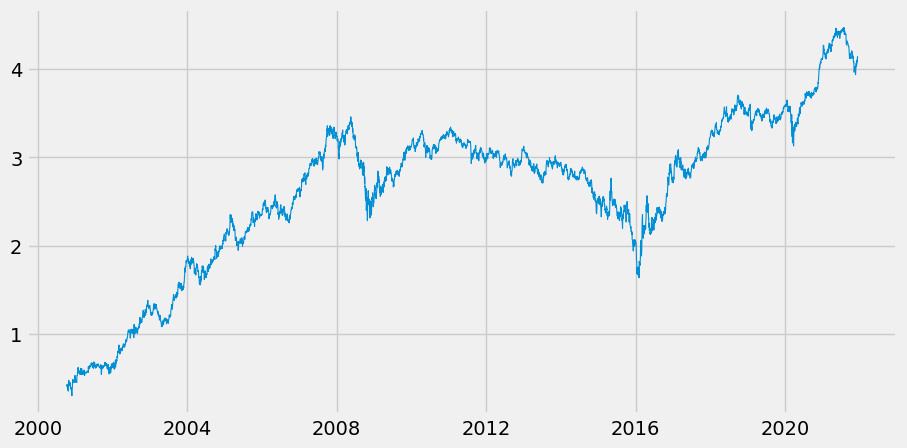

In [79]:
fc = fitted.forecast(1000)

# Criar a série de previsões e os intervalos de confiança
fc_series = pd.Series(fc, index=test_data.index)
# lower_series = pd.Series(conf_int[:, 0], index=test_data.index)
# upper_series = pd.Series(conf_int[:, 1], index=test_data.index)

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='Training Data', linewidth=0.8)
plt.plot(test_data, color='blue', label='Actual Stock Price', linewidth=0.8)
plt.plot(fc_series, color='orange', label='Predicted Stock Price', linewidth=1)
#plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.title('ARCH CAPITAL GROUP Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('ARCH CAPITAL GROUP Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()